
# Tarea N°02
## Instrucciones
1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.

**Nombre**: Alan Grez Jimenez

**Rol**: 201710519-4

2.- Debes pushear este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:

- Soluciones
- Código
- Que Binder esté bien configurado.
- Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import missingno as msno
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits_dict = datasets.load_digits()
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


Ahora veremos si existen datos faltantes:

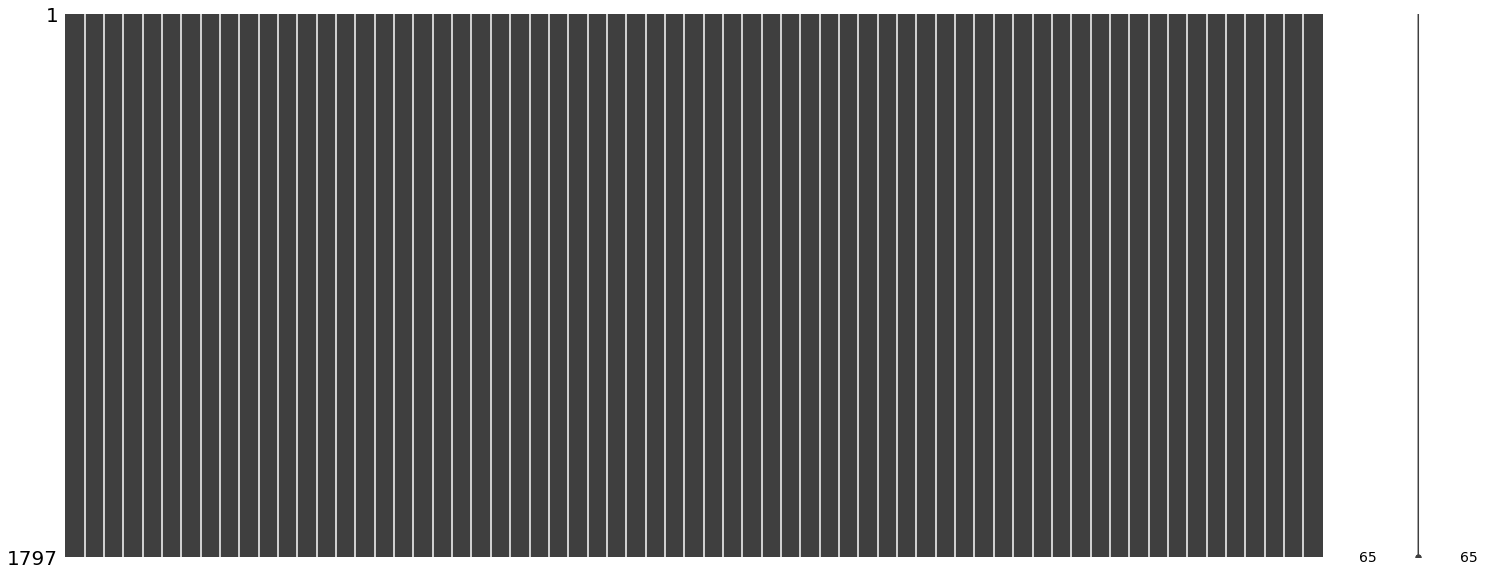

In [6]:
msno.matrix(digits.dropna())

No existen datos faltantes. Ahora, veamos una visualización por target.

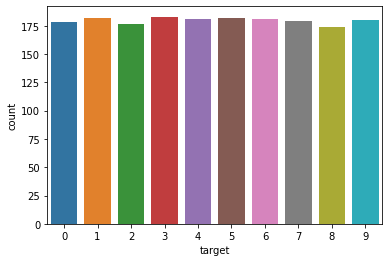

In [7]:
import seaborn as sns
sns.countplot(x='target',data=digits)

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [8]:
digits_dict['images'][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

In [9]:
# Hagamos un pequeño trabajo de índices y nombres.
#indx

nx, ny = 5, 5
indx = [ ]
for i in range(nx):
    for j in range(ny):
        indx.append( (i,j) )
        
#name        
name = [ ]
for k in range(nx*ny):
    if k < 10:
        name.append( "c0"+str(k) )
    else:
        name.append( "c"+str(k)  )



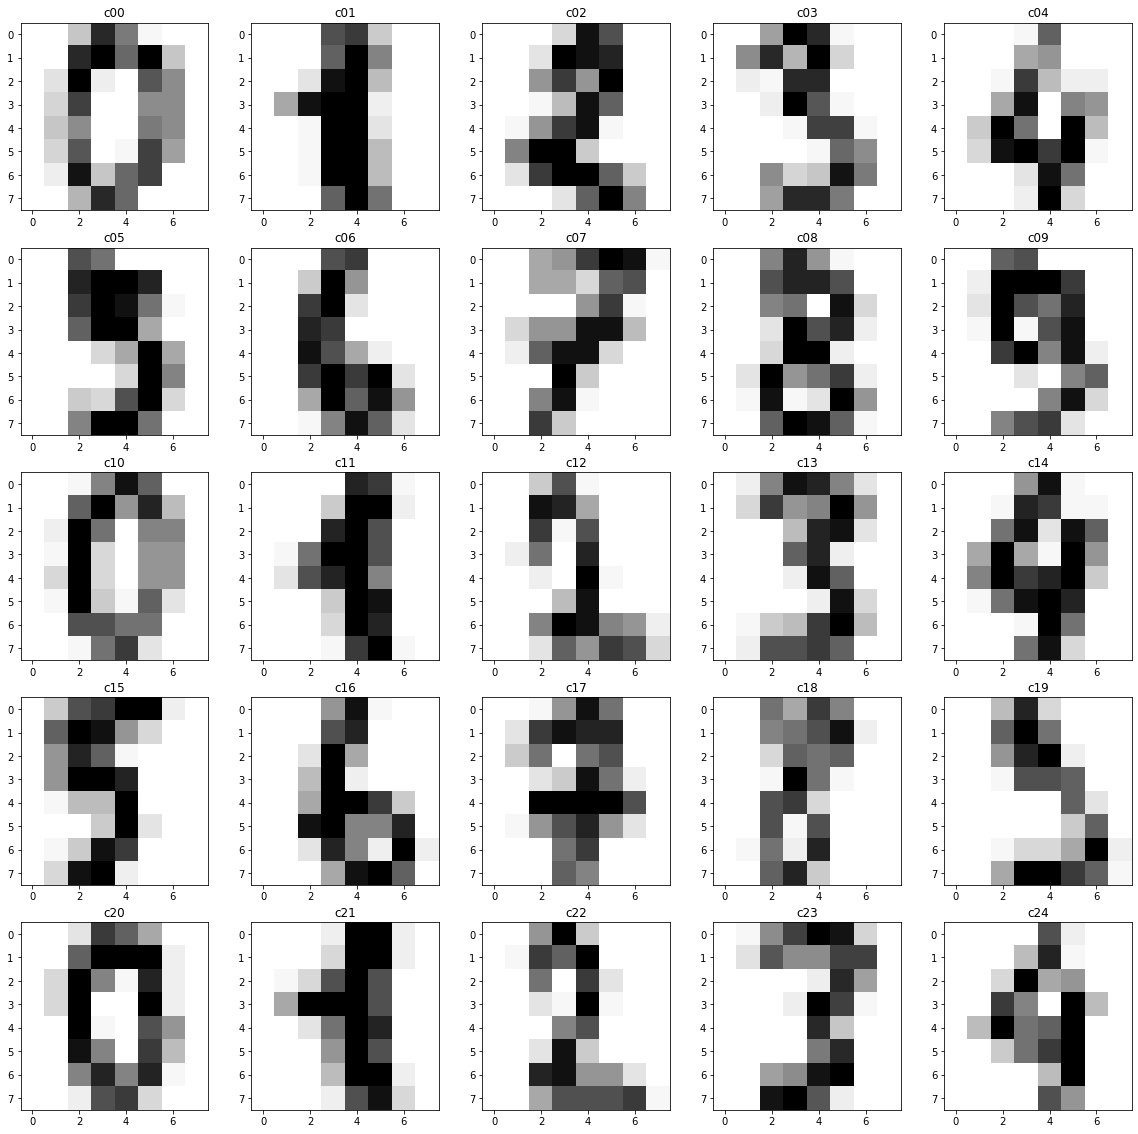

In [10]:
fig, axs = plt.subplots(nx, ny, figsize=(20, 20))
for k in range(nx*ny):
    i,j = indx[k]
    axs[i,j].imshow(digits_dict["images"][k],cmap='Greys')
    axs[i][j].set_title(name[k])
plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


### Train test

In [11]:
# datos 
X = digits.drop(columns="target").values
y = digits["target"].values

from sklearn.model_selection import train_test_split

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)
# print rows train and test sets
print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1437
numero de filas test set      :  360


### Modelo

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [13]:
# Logistic Regression

LogReg_params = {'tol':[1e-4,1e-5], 'C': [1.0,5.0,10.0],'solver': ['newton-cg'], 'max_iter':range(1500,2500,100)}

rlog = GridSearchCV(LogisticRegression(max_iter=3000),LogReg_params)
rlog.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=3000),
             param_grid={'C': [1.0, 5.0, 10.0],
                         'max_iter': range(1500, 2500, 100),
                         'solver': ['newton-cg'], 'tol': [0.0001, 1e-05]})

In [14]:
# K-Nearest Neighbours

Neigh_params = {'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), 'leaf_size': (20,30,40),
                'n_neighbors':(4,10,15,20), 'weights': ('uniform', 'distance')}

neigh = GridSearchCV(KNeighborsClassifier(),Neigh_params)
neigh.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'leaf_size': (20, 30, 40),
                         'n_neighbors': (4, 10, 15, 20),
                         'weights': ('uniform', 'distance')})

In [15]:
# A elección: svm.SVC

SVC_params = {'C':range(1,10),'degree':range(1,5),'kernel':('poly', 'rbf', 'sigmoid')}

svm_svc = GridSearchCV(svm.SVC(),SVC_params)
svm_svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': range(1, 10), 'degree': range(1, 5),
                         'kernel': ('poly', 'rbf', 'sigmoid')})

In [16]:
# A elección: svm.SVC

Rand_Forest_params = {'n_estimators':range(1,100,10),'criterion':['gini','entropy'],'min_samples_split':range(2,5),
                      'min_samples_leaf':range(1,5)}

randForest = GridSearchCV(RandomForestClassifier(),Rand_Forest_params)
randForest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 5),
                         'n_estimators': range(1, 100, 10)})

In [17]:
#Hiper-Parámetros
print("Hiper-Parámetros: ")
print( "Logistic Regression:  "+ str(rlog.cv_results_['params'][0]))
print("KNeighborsClassifier: " + str(neigh.cv_results_['params'][0]))
print( "svm.SVC:           "+ str(svm_svc.cv_results_['params'][0]))
print( "RandomForestClassifier:    "+ str(randForest.cv_results_['params'][0]))

Hiper-Parámetros: 
Logistic Regression:  {'C': 1.0, 'max_iter': 1500, 'solver': 'newton-cg', 'tol': 0.0001}
KNeighborsClassifier: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 4, 'weights': 'uniform'}
svm.SVC:           {'C': 1, 'degree': 1, 'kernel': 'poly'}
RandomForestClassifier:    {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1}


En consecuencia, los mejores modelos son:

In [18]:
train_times = {}

# Regresión Logística.
rlog = LogisticRegression(C= 1.0, solver ='newton-cg', tol = 0.0001,max_iter=1500)
t1=time.time()
rlog.fit(X_train, y_train) # ajustando el modelo
train_times["LogisticRegression"]= time.time() - t1

# K-Nearest Neighbours
neigh = KNeighborsClassifier(algorithm = 'auto', leaf_size = 20, n_neighbors = 4, weights = 'uniform')
t1=time.time()
neigh.fit(X_train, y_train)
train_times["KNeighborsClassifier"] = time.time() - t1

# A elección: svm.SVC
svm_svc = svm.SVC( degree= 1,kernel = 'poly')
t1=time.time()
svm_svc.fit(X_train, y_train)
train_times["svm.SVC"]= time.time() - t1

# A elección: RandomForestClassifier
randForest = RandomForestClassifier(criterion= 'gini', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1)
t1=time.time()
randForest.fit(X_train, y_train)
train_times["RandomForestClassifier"]= time.time() - t1

print('Los tiempos de entrenamiento son:')
for model,tiempo in train_times.items():
    print("El tiempo de entrenamiento del modelo: {m} es {t}".format(m = model,t = tiempo))

Los tiempos de entrenamiento son:
El tiempo de entrenamiento del modelo: LogisticRegression es 9.809859991073608
El tiempo de entrenamiento del modelo: KNeighborsClassifier es 0.02494215965270996
El tiempo de entrenamiento del modelo: svm.SVC es 0.0557858943939209
El tiempo de entrenamiento del modelo: RandomForestClassifier es 0.005047321319580078


### Métricas

In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score

In [20]:
for model in [rlog, neigh, svm_svc,randForest]:
    print('##################### {m} #####################'.format(m = str(model)))
    y_true =  list(y_test)
    y_pred = list(model.predict(X_test))


    print('\nMatriz de confusion:\n ')
    print(confusion_matrix(y_true,y_pred))

    print('\nMetricas:\n ')
    print('accuracy:   ',accuracy_score(y_true,y_pred))
    print('recall:     ',recall_score(y_true,y_pred,average='weighted'))
    print('precision:  ',precision_score(y_true,y_pred,average='weighted'))
    print('f-score:    ',f1_score(y_true,y_pred,average='weighted'))
    print("")

##################### LogisticRegression(max_iter=1500, solver='newton-cg') #####################

Matriz de confusion:
 
[[31  0  0  0  1  0  0  0  0  0]
 [ 0 41  0  1  0  0  0  0  1  1]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  0  0  2  1  0]
 [ 0  0  0  0 31  0  0  0  3  1]
 [ 0  1  0  0  1 40  0  0  0  1]
 [ 0  1  0  0  0  0 33  0  1  0]
 [ 0  0  0  0  0  0  0 39  0  1]
 [ 0  0  0  0  1  0  0  0 34  1]
 [ 0  0  0  0  0  1  0  0  1 26]]

Metricas:
 
accuracy:    0.9416666666666667
recall:      0.9416666666666667
precision:   0.944844330702475
f-score:     0.9424086721254218

##################### KNeighborsClassifier(leaf_size=20, n_neighbors=4) #####################

Matriz de confusion:
 
[[32  0  0  0  0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  1  0  0]
 [ 0  0  0  0 33  0  0  1  1  0]
 [ 0  0  0  0  0 43  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0]
 [ 0  1  0  0  0  0  0  

Luego de realizar y comprar cuatro modelos, podemos afirmar que quien tiene mayor precisión es *KNeighborsClassifier(leaf_size=20, n_neighbors=4)* considerando que es el segundo más rápido en después de *RandomForestClassifier*, es por esto, que nos mantendremos trabajando con *KNeighborsClassifier*

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

**Cross Validation:**

In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(neigh, X, y, cv=10)
print("Precisión: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Precisión: 0.97 (+/- 0.03)


**Curva de Validación**

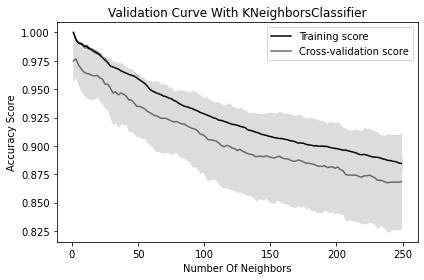

In [22]:
from sklearn.model_selection import validation_curve

# Create range of values for parameter
param_range = np.arange(1, 250, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(neigh, X, y, param_name="n_neighbors", param_range=param_range,
                                             cv=10, scoring="accuracy", n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With KNeighborsClassifier")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

**Curva AUC–ROC**

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

y_test=label_binarize(y_test, classes=[i for i in range(10)])

# K-Nearest Neighbours
neigh = KNeighborsClassifier(algorithm = 'auto', leaf_size = 20, n_neighbors = 4, weights = 'uniform')

y_score = neigh.fit(X_train, y_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [24]:
nx, ny = 2, 5
indx = [ ]
for i in range(nx):
    for j in range(ny):
        indx.append( (i,j) )
        
#name        
name = [ ]
for k in range(nx*ny):
    if k < 10:
        name.append( "c0"+str(k) )
    else:
        name.append( "c"+str(k)  )

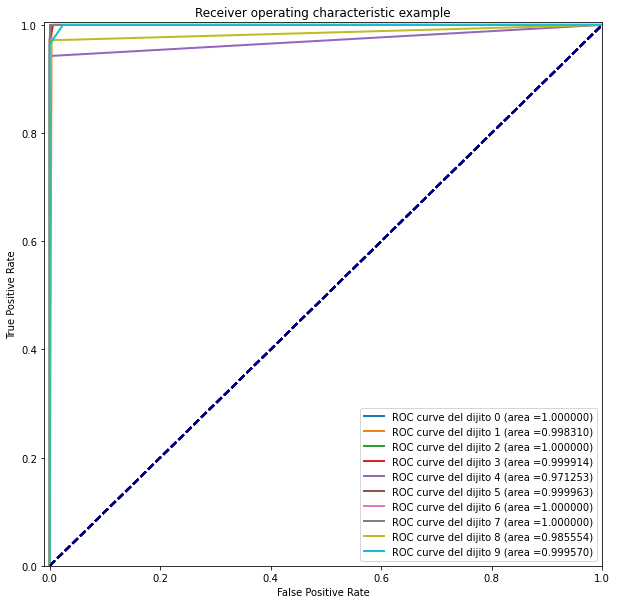

In [25]:
plt.figure(figsize=(10,10))
lw = 2
for i in range(10):
    
    plt.plot(fpr[i], tpr[i],
             lw=lw, label='ROC curve del dijito {0} (area ={1:f})'
             ''.format(i,roc_auc[i])   )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.005])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
plt.show()


### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


Comparemos los métodos de **selección de atributos** a través de *SelectKBest* y **Extracción de atributos** a través de *análisis de componentes principales (PCA)*

### Selección de atributos: SelectKBest

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [27]:
# Aplicando el algoritmo univariante de prueba F.
k = 20  # número de atributos a seleccionar
# Seleccionamos 25 atributos dado que en PCA, trabajaremos con las 25 componentes principales.
# Separamos las columnas objetivo

columnas      = list(digits.drop(['target'], axis= 1).columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(X_train, y_train)

In [28]:
catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]

Para lo cual, trabajeremos con la selección:

['c02',
 'c10',
 'c13',
 'c18',
 'c19',
 'c20',
 'c21',
 'c26',
 'c27',
 'c28',
 'c30',
 'c33',
 'c34',
 'c35',
 'c36',
 'c38',
 'c42',
 'c43',
 'c44',
 'c46',
 'c53',
 'c54',
 'c58',
 'c60',
 'c61']
 
 Que nos entrega *SelectKBest*.

### Extracción de atributos: PCA

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [30]:
# Reescalamiento de los datos.
X_new = StandardScaler().fit_transform(X_train)

In [31]:
# Ajuste modelo
pca = PCA(n_components = 64)
principalComponents = pca.fit_transform(X_new)

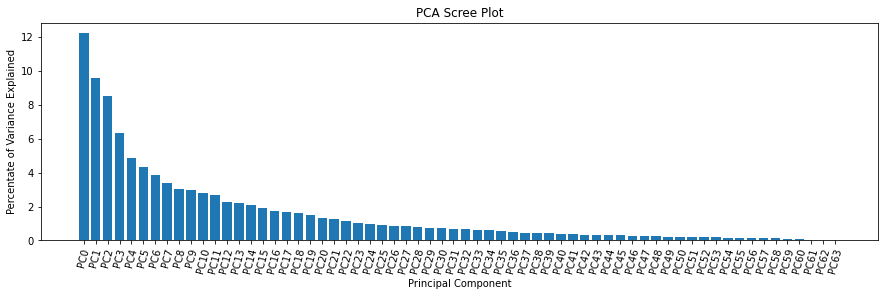

In [32]:
# Graficar varianza por componente
percent_variance = pca.explained_variance_ratio_* 100
columns = [ "PC{j}".format(j = i) for i in range(64)]

plt.figure(figsize=(15,4))
plt.bar(x= range(1,65), height=percent_variance, tick_label=columns)
plt.xticks(rotation=75)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

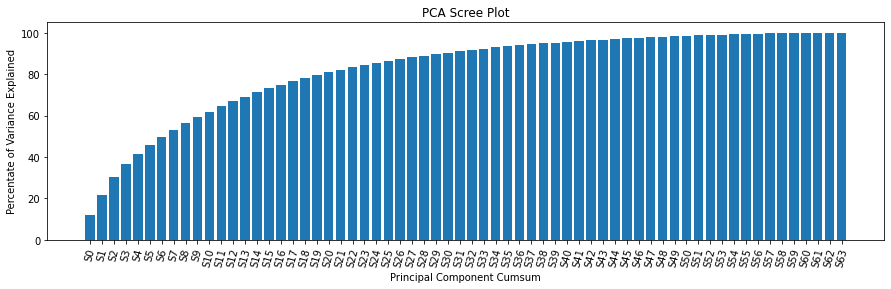

In [33]:
# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)
columns = [ "S{j}".format(j = i) for i in range(64)]

plt.figure(figsize=(15,4))
plt.bar(x= range(1,65), height=percent_variance_cum , tick_label=columns)
plt.xticks(rotation=75)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.show()

In [34]:
percent_variance_cum[39]
#percent_variance_cum

95.2840694237342

Es decir, que la varianza explicada de las variables se puede explicar en 95.08% considerando solo las 39 primeras componentes principales. Realicemos el ajuste para las 39 componentes principales y realicemos la nueva gráfica proyectada a estas componentes

In [35]:
pca = PCA(n_components=39)

principalComponents = pca.fit_transform(X_train)

principalDataframe = pd.DataFrame(data = principalComponents, columns = [ "PC{j}".format(j = i) for i in range(39)])
targetDataframe    = digits[['target']]

newDataframe = pd.concat([principalDataframe, targetDataframe],axis = 1)
newDataframe.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,target
0,13.616964,5.519842,4.853028,-8.619865,12.856710,7.773365,-7.812922,0.035710,10.521103,1.290677,...,2.475221,-2.530286,2.892201,2.518035,-0.570736,-1.157519,-1.444570,3.542693,2.916374,0
1,8.413611,-12.968359,22.594993,1.134795,-10.819527,-2.463729,-0.838928,4.557264,-1.171966,-4.158274,...,1.507641,1.077804,4.269874,-0.324190,-2.358904,0.290623,-0.757176,2.410937,-1.148624,1
2,2.855517,-1.481470,31.391697,1.195570,-1.911764,-5.836886,-2.287078,3.607397,-2.533299,-11.591694,...,1.437987,2.524964,2.672833,0.755494,-3.409581,-1.465659,-2.790655,1.957371,-0.916352,2
3,23.857436,1.012902,7.317212,-8.024145,-1.032505,14.192235,-5.640512,10.813732,-3.733704,2.344201,...,-0.963641,-2.082290,1.689796,-1.045331,0.464026,-2.733433,-2.172026,1.792544,-1.501660,3
4,17.107491,-1.355271,-3.947983,-8.060231,1.464014,-0.846935,-1.127652,5.334005,4.623728,4.400413,...,1.477304,1.276868,1.951268,-1.406369,-1.073669,-0.269251,-0.621677,-1.926643,0.278108,4


### Comparación

Ahora, comparemos los modelos.

In [36]:
# datos 
X = digits.drop(columns="target").values
y = digits["target"].values

train_times        = {}
cantidad_atributos = {}

In [37]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)
cantidad_atributos["KNC_original"] = [X_train.shape[1]]

# print rows train and test sets
print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

# K-Nearest Neighbours
original = KNeighborsClassifier(algorithm = 'auto', leaf_size = 20, n_neighbors = 4, weights = 'uniform')
t1 = time.time()
original.fit(X_train, y_train)
train_times["KNC_original"] = [time.time() - t1]

model = original
print('##################### {m} #####################'.format(m = str(model)))
y_true =  list(y_test)
y_pred = list(model.predict(X_test))


print('\nMatriz de confusion:\n ')
print(confusion_matrix(y_true,y_pred))

print('\nMetricas:\n ')
print('accuracy:   ',accuracy_score(y_true,y_pred))
print('recall:     ',recall_score(y_true,y_pred,average='weighted'))
print('precision:  ',precision_score(y_true,y_pred,average='weighted'))
print('f-score:    ',f1_score(y_true,y_pred,average='weighted'))
print("")

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1437
numero de filas test set      :  360
##################### KNeighborsClassifier(leaf_size=20, n_neighbors=4) #####################

Matriz de confusion:
 
[[32  0  0  0  0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  1  0  0]
 [ 0  0  0  0 33  0  0  1  1  0]
 [ 0  0  0  0  0 43  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0]
 [ 0  1  0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  1  0  1  0 26]]

Metricas:
 
accuracy:    0.9833333333333333
recall:      0.9833333333333333
precision:   0.9840395883903637
f-score:     0.9833113636560299



In [38]:
# PCA
pca = PCA(n_components=39)

X_new = pca.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, test_size=0.2, random_state = 2)
cantidad_atributos["PCA_39"] = [X_train.shape[1]]

kn_pca = KNeighborsClassifier(algorithm = 'auto', leaf_size = 20, n_neighbors = 4, weights = 'uniform')
t1 = time.time()
kn_pca.fit(X_train, y_train)


train_times["PCA_39"] = [time.time() - t1]

model = kn_pca
print('##################### {m} #####################'.format(m = str(model)))
y_true =  list(y_test)
y_pred = list(model.predict(X_test))


print('\nMatriz de confusion:\n ')
print(confusion_matrix(y_true,y_pred))

print('\nMetricas:\n ')
print('accuracy:   ',accuracy_score(y_true,y_pred))
print('recall:     ',recall_score(y_true,y_pred,average='weighted'))
print('precision:  ',precision_score(y_true,y_pred,average='weighted'))
print('f-score:    ',f1_score(y_true,y_pred,average='weighted'))
print("")

##################### KNeighborsClassifier(leaf_size=20, n_neighbors=4) #####################

Matriz de confusion:
 
[[32  0  0  0  0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  1  0  0]
 [ 0  0  0  0 33  0  0  2  0  0]
 [ 0  0  0  0  0 43  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0]
 [ 0  1  0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  1  0  1  0 26]]

Metricas:
 
accuracy:    0.9833333333333333
recall:      0.9833333333333333
precision:   0.9844682940516274
f-score:     0.9834057496956049



In [39]:
# SelectKBest.
# atributos: lista de los atributos seleccionados por SelectKBest
X_train, X_test, y_train, y_test = train_test_split(digits[atributos], y, test_size=0.2, random_state = 2)
cantidad_atributos["SKB_KNC"] = [X_train.shape[1]]

# train new model
neigh_skb = KNeighborsClassifier(algorithm = 'auto', leaf_size = 20, n_neighbors = 4, weights = 'uniform')
t1=time.time()
neigh_skb.fit(X_train, y_train)
train_times["SKB_KNC"] = [time.time() - t1]

model = neigh_skb
print('##################### {m} #####################'.format(m = str(model)))
y_true =  list(y_test)
y_pred = list(model.predict(X_test))


print('\nMatriz de confusion:\n ')
print(confusion_matrix(y_true,y_pred))

print('\nMetricas:\n ')
print('accuracy:   ',accuracy_score(y_true,y_pred))
print('recall:     ',recall_score(y_true,y_pred,average='weighted'))
print('precision:  ',precision_score(y_true,y_pred,average='weighted'))
print('f-score:    ',f1_score(y_true,y_pred,average='weighted'))
print("")

##################### KNeighborsClassifier(leaf_size=20, n_neighbors=4) #####################

Matriz de confusion:
 
[[32  0  0  0  0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  0  0  2  0  1]
 [ 0  0  0  0 31  0  0  3  0  1]
 [ 0  0  0  1  1 41  0  0  0  0]
 [ 1  0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0]
 [ 0  2  1  0  0  0  0  0 33  0]
 [ 0  0  0  1  0  0  0  1  0 26]]

Metricas:
 
accuracy:    0.9583333333333334
recall:      0.9583333333333334
precision:   0.9605006260848653
f-score:     0.9583436902927607



In [40]:
print("Los tiempos de entrenamiento son: ")
print("KNC_original: "+str(train_times["KNC_original"][0]))
print("PCA_39:       "+str(train_times["PCA_39"][0]))
print("SKB_KNC:      "+str(train_times["SKB_KNC"][0]))

Los tiempos de entrenamiento son: 
KNC_original: 0.028579235076904297
PCA_39:       0.015625953674316406
SKB_KNC:      0.015964031219482422


In [41]:
print("La cantidad de atributos considerados del dataset son: ")
print("KNC_original: "+str(cantidad_atributos["KNC_original"][0]))
print("PCA_39:       "+str(cantidad_atributos["PCA_39"][0]))
print("SKB_KNC:      "+str(cantidad_atributos["SKB_KNC"][0]))

La cantidad de atributos considerados del dataset son: 
KNC_original: 64
PCA_39:       39
SKB_KNC:      20


In [42]:
#plt.figure(figsize=(12,4))
#plt.bar(x= range(1,4), height=list(cantidad_atributos.values()), tick_label=list(cantidad_atributos.keys()))
#plt.ylabel('Modelo')
#plt.xlabel('Número de atributos')
#plt.title('Gráfica comparativa')
#plt.show()

In [43]:
np.array(list(cantidad_atributos.values())).T[0]

array([64, 39, 20])

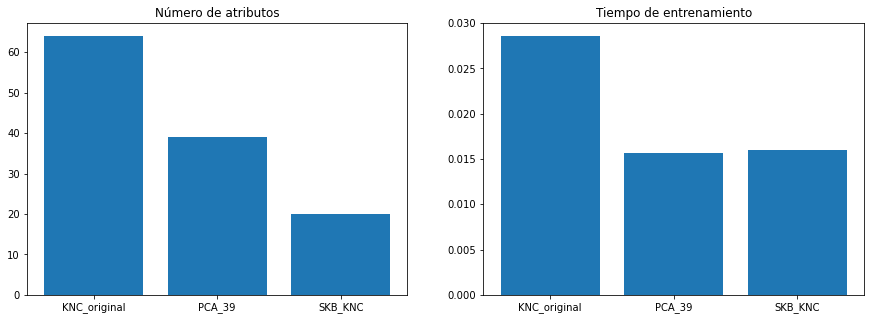

In [44]:
# Figure
fig, axs = plt.subplots(1, 2 , figsize=(15, 5) )

nombres = list(cantidad_atributos.keys())
datos   = np.array(list(cantidad_atributos.values())).T[0]
xx = range(len(datos))
axs[0].set_title('Número de atributos')
axs[0].bar(xx, datos, width=0.8, align='center')
axs[0].set_xticks(xx)
axs[0].set_xticklabels(nombres)


datos   = np.array(list(train_times.values())).T[0]
axs[1].set_title('Tiempo de entrenamiento')
axs[1].bar(xx, datos, width=0.8, align='center')
axs[1].set_xticks(xx)
axs[1].set_xticklabels(nombres)
plt.show()

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [45]:
def mostar_resultados(digits,model,nx=3, ny=3,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model:  modelo de sklearn
    :param nx:     numero de filas (subplots)
    :param ny:     numero de columnas (subplots)
    :param label:  datos correctos o incorrectos
    
    :return: graficos matplotlib
    """
    digits_dict = datasets.load_digits()
    digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
    )

    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = np.array(y_test)[mask]
    y_aux_pred = np.array(y_pred)[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

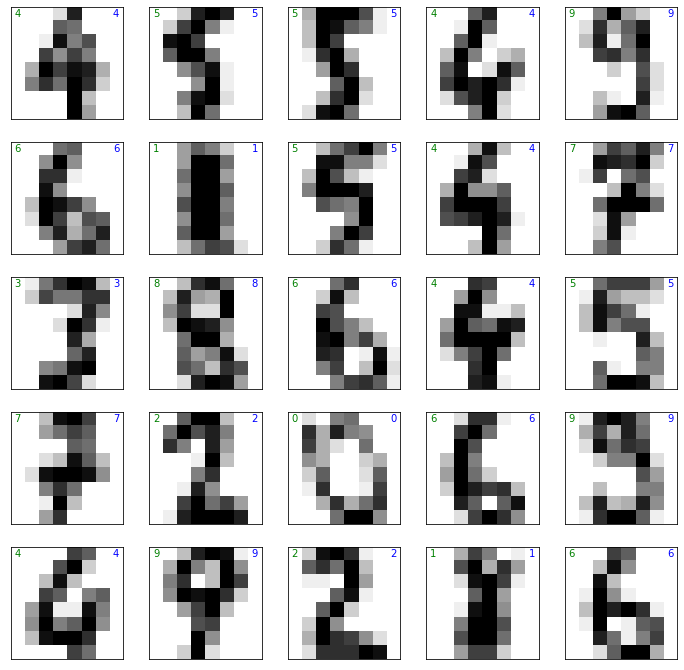

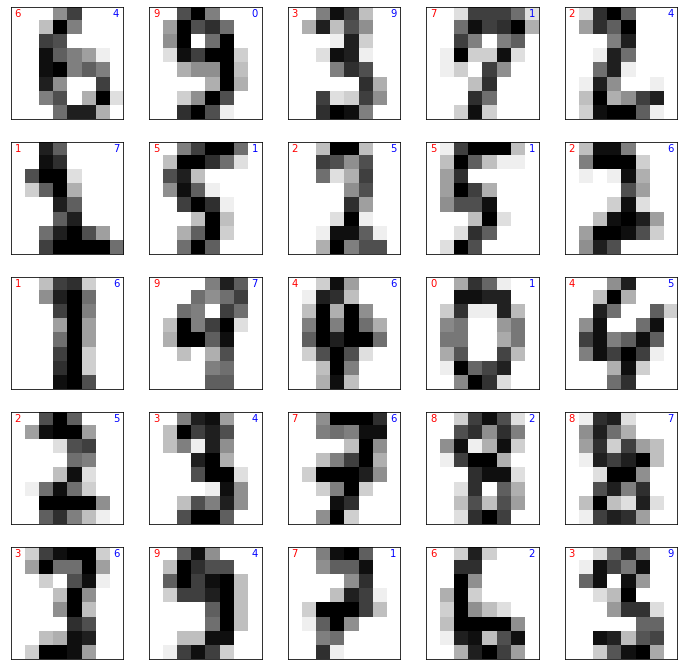

In [46]:
model = KNeighborsClassifier(leaf_size = 20, n_neighbors = 4, weights = 'uniform')
mostar_resultados(digits, model, nx=5, ny=5, label = "correctos")
mostar_resultados(digits, model, nx=5, ny=5, label = "incorrectos")

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

Primero, dado que conocimos la visualización de datos, la primera impresión que nos entregó es que con tan poca información como lo era una foto de 8x8 bytes era que difícilmente nuestro modelo sería capaz de clasificar correctamente, no obstante si fue capaz.

Segundo, del apartado 6, podemos rescatar que nuestro modelo ya era preciso aún disminuyendo el número de atributos a 20, es decir, quitando derechamente como tal pixeles de nuestras fotos pertenecientes al dataset.

En conclusión y sumado a todo lo anterior, cualquiera podría pensar que se necesitaría una alta resolución sobre la captura de datos para entrenar un modelo robusto, para lo cual demostramos lo contrario contra toda intuición. 

Entonces, para trabajos futuros se podría pensar en simplemente una captura de datos que no necesariamente involcre una gran resolución o no invertir en agentes de gran fidelidad, siendo que bastaba una resolución de 8x8.